In [3]:
# I decided to do the SQL queries here using DuckDB. I think this brings a
# better way to check the code

import duckdb
import pandas as pd

To choose which questions would be answered, I literally randomized them to have an approach closer to how things work on the business routine and also to challenge myself. These were the three chosen:

1. What are the top 5 brands by sales among users that have had their account for at least six months?
2. Who are Fetch’s power users?
3. At what percent has Fetch grown year over year?

In [4]:
# Defining variables for CLEAN datasets' url's
url_csv_user = "https://drive.google.com/uc?id=1ve8S_NJ1fXC1qvp1UAxFSg_lCsuP3OD-"
url_csv_transaction = "https://drive.google.com/uc?id=1LsRTDX1_tJbbuj-3zOForh5V81JdDi39"
url_csv_products = "https://drive.google.com/uc?id=1ClrYURjbnyeCkI9KqUPr43IjZsbRYGi5"

In [5]:
# Loading CSV's to Dataframe
df_user = pd.read_csv(url_csv_user, parse_dates=['CREATED_DATE'])
df_transaction = pd.read_csv(url_csv_transaction, parse_dates=['PURCHASE_DATE'])
df_product = pd.read_csv(url_csv_products)

# Registering to DuckDB's virtual memory so we don't need to load the CSV on each query
con = duckdb.connect()
con.register('fetch_user', df_user)
con.register('fetch_transaction', df_transaction)
con.register('fetch_product', df_product)

# And now let's go to the SQLs

# What are the top 5 brands by sales among users that have had their account for at least six months?


In [6]:
query_1q = """
SELECT
    p.brand,
    SUM(t.FINAL_SALE) AS total_sales
FROM
    fetch_transaction t
INNER JOIN
    fetch_product p ON t.barcode = p.barcode
INNER JOIN
    fetch_user u ON t.user_id = u.id
WHERE
    CAST (u.created_date as DATE) <= CAST (t.purchase_date as DATE) - INTERVAL 180 DAY AND
    p.brand IS NOT NULL
GROUP BY
    p.brand
ORDER BY
    total_sales DESC
LIMIT 5;


"""
result_1q = con.execute(query_1q).fetchdf()
print(result_1q)

# We have a huge amount of products with no information about their brands. This
# limitates the results for few transactions, making the final sales low even
# for the top 5 brands.


         BRAND  total_sales
0          CVS        72.00
1         DOVE        30.91
2      TRIDENT        23.36
3  COORS LIGHT        17.48
4     TRESEMMÉ        14.58


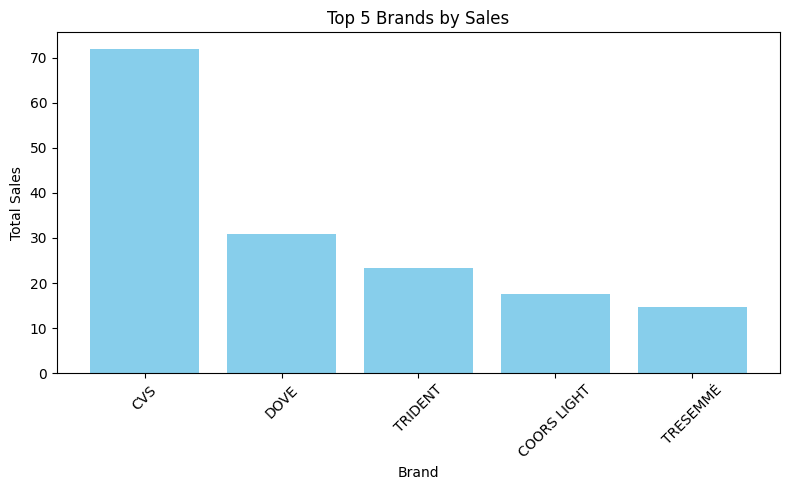

In [10]:
# Visualizing the brands in a chart for better understanding

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
# Accessing columns from the result DataFrame instead of the query string
plt.bar(result_1q['BRAND'], result_1q['total_sales'], color='skyblue')
plt.title("Top 5 Brands by Sales")
plt.xlabel("Brand")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Who are Fetch’s power users?

There are some ways to determine what defines a power user:

*   The users with the most spend all over the time
*   The users with more purchases all over the time
*   The users with most recurrent purchases
*   The most recent users that made at least one purchase

But we can get to a more sophisticated view, unifying all of them:
In CRM, it's very common to use a framework to determine the type of communication that the users will receive. It's called RFV Matrix and it's defined by three measures: Recency, Frequency and Value of the purchases made at user level.

And in our takehome we have the data needed to do these three measures.

In each one of the three measures, we can define cutoffs to give levels 1, 2 and 3 for that user. On the Value KPI, for example, we can determine that users with more than $100 in purchase are already important to us, so we can give him/her a 3.

We could determine the cutoffs for each level and each measure if we want to do a most consistent CRM plan. But since we are answering only the power users for this question, we can determine the values only to them. They will be on the SQL code below.

The cutoffs were determined according to the info we have about the purchases and the users. The number of power users can be lower or higher depending on what will be the actions, studies or campaigns made with them. The cutoff definition can also be less "dumb" and based on percentiles.

In [12]:
query_2q = """

WITH last_date AS (
    SELECT MAX(purchase_date) AS max_date
    FROM fetch_transaction
),

filtered_transactions AS (
    SELECT
        t.user_id,
        t.receipt_id,
        t.final_sale,
        t.purchase_date,
        DATEDIFF('day', t.purchase_date, l.max_date) AS recency
    FROM fetch_transaction t
    INNER JOIN last_date l ON 1=1
    WHERE
        t.purchase_date >= l.max_date - INTERVAL '60' DAY
),

aggregated_users AS (
    SELECT
        user_id,
        MIN(recency) AS recency,
        COUNT(DISTINCT receipt_id) AS frequency,
        SUM(final_sale) AS total_value
    FROM filtered_transactions
    GROUP BY user_id
)

SELECT
    user_id,
    recency,
    frequency,
    total_value
FROM aggregated_users
WHERE
    frequency >= 3
    AND total_value >= 30
ORDER BY
    total_value DESC;


"""

result_2q = con.execute(query_2q).fetchdf()
print(result_2q)

                     USER_ID  recency  frequency  total_value
0   645add3bffe0d7e043ef1b63        5          3       227.93
1   637257e75fdbb03aa198a310       18          4       104.14
2   60a5363facc00d347abadc8e        2          3        67.04
3   62535ab0fc0da6299a70f5ca       16          3        60.46
4   5d77d06b0d1bff4316a3ef47       14          6        57.21
5   61d0aa0c52baef1444b555f6       28          3        56.22
6   63d8337b55e4cd39e5e17ede       19          3        53.88
7   5f906764542e501679d188f4       19          4        52.93
8   65845b6bc9e6fe40ea67e108        4          3        50.37
9   5c13acf1efb01c1db2c4675c        4          3        43.97
10  643b0c77347839fdfa97cce3       26          4        43.26
11  638d0bb590ad5449ec5a76ce        2          3        42.99
12  605a982894a5c74ba439e5ab        0          6        41.89
13  62473c74834ddd30c4f13895       14          3        41.45
14  64e798baca929250373ea30d        3          4        40.36
15  60c8

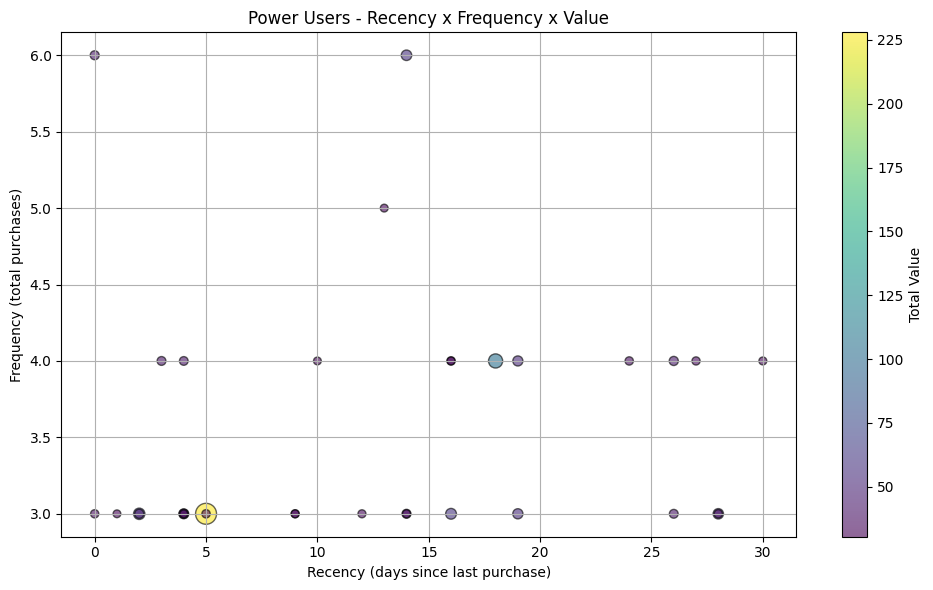

In [14]:
# Visualizing

plt.figure(figsize=(10, 6))
plt.scatter(
    result_2q["recency"],
    result_2q["frequency"],
    s=result_2q["total_value"],
    alpha=0.6,
    c=result_2q["total_value"],
    cmap="viridis",
    edgecolors="k"
)

plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Frequency (total purchases)")
plt.title("Power Users - Recency x Frequency x Value")
plt.colorbar(label="Total Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# At what percent has Fetch grown year over year?

We lack of some data for a better answer about this. For example:
- The total sales for the same period of user data. We only have data for some months of 2024. With this, we could calculate not only the total users, but also see what users **are active** and have a growth between years
- Other P&L measures to calculate KPI's more connected to real profit, contribution margin etc.

In [32]:
query_3q = """

WITH base AS (
  SELECT
    DATE_TRUNC('year', created_date) AS year,
    COUNT(id) AS user_count,
    COUNT(id) * 1.0 /
      DATEDIFF('day', DATE_TRUNC('year', MIN(created_date)), MAX(created_date)) AS daily_avg,
    MAX(created_date) AS max_date
  FROM fetch_user
  GROUP BY year
),

projected AS (
  SELECT
    year,
    CASE
      WHEN year = DATE_TRUNC('year', CURRENT_DATE)
      THEN CAST(ROUND(daily_avg * 365) AS INTEGER)  -- projeção p/ o ano inteiro
      ELSE user_count
    END AS estimated_user_count
  FROM base
),

growth AS (
  SELECT
    year,
    estimated_user_count,
    LAG(estimated_user_count) OVER (ORDER BY year) AS previous_year_count,
    ROUND(
      100.0 * (estimated_user_count - LAG(estimated_user_count) OVER (ORDER BY year))
      / NULLIF(LAG(estimated_user_count) OVER (ORDER BY year), 0),
      2
    ) AS growth_percentage
  FROM projected
)

SELECT * FROM growth ORDER BY year;

"""

result_3q = con.execute(query_3q).fetchdf()
print(result_3q)

         year  estimated_user_count  previous_year_count  growth_percentage
0  2014-01-01                    30                 <NA>                NaN
1  2015-01-01                    51                   30              70.00
2  2016-01-01                    70                   51              37.25
3  2017-01-01                   644                   70             820.00
4  2018-01-01                  2168                  644             236.65
5  2019-01-01                  7093                 2168             227.17
6  2020-01-01                 16883                 7093             138.02
7  2021-01-01                 19159                16883              13.48
8  2022-01-01                 26807                19159              39.92
9  2023-01-01                 15462                26807             -42.32
10 2024-01-01                 11604                15462             -24.95


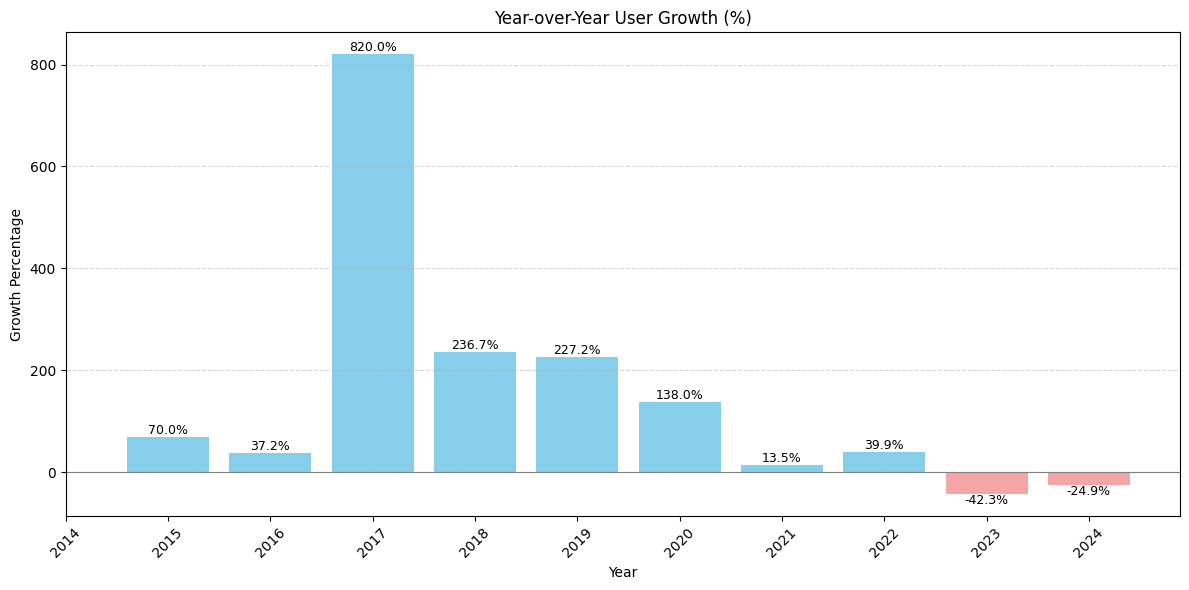

In [33]:
# Visualizing

result_3q['year'] = pd.to_datetime(result_3q['year']).dt.year

# Define cores suaves para positivo (azul) e negativo (vermelho)
colors = ['skyblue' if val >= 0 else '#f4a6a6' for val in result_3q['growth_percentage']]  # vermelho claro

plt.figure(figsize=(12, 6))
bars = plt.bar(result_3q['year'], result_3q['growth_percentage'], color=colors)

# Adiciona os valores no topo das colunas
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%',
             va='bottom' if yval >= 0 else 'top', ha='center', fontsize=9)

plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Year-over-Year User Growth (%)')
plt.xlabel('Year')
plt.ylabel('Growth Percentage')
plt.xticks(result_3q['year'], rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()